In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Data

## Data Loading

In [2]:
from src.data import download_data

In [3]:
download_data(force_download=False)

## Data Analysis and Cleaning

In [4]:
from src.data import load_characters, load_movies, load_movies_and_plots, load_plots
# load all tables
movies = load_movies()
characters = load_characters()
plots = load_plots()

In [5]:
show_amount = 2

print(f"Movie Metadata of shape {movies.shape}:")
display(movies.head(show_amount))

print(f"\nCharacter Metadata of shape {characters.shape}:")
display(characters.head(show_amount))

print(f"\nPlot Summaries of shape {plots.shape}:")
display(plots.head(show_amount))

Movie Metadata of shape (81741, 9):


,WikipediaId,FreebaseId,MovieName,ReleaseDate,Revenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."



Character Metadata of shape (450669, 13):


,WikipediaId,FreebaseId,ReleaseDate,CharacterName,ActorDateOfBirth,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtRelease,FreebaseCharacterActorMapId,FreebaseCharId,FreebaseActorId
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4



Plot Summaries of shape (42303, 2):


,WikipediaId,PlotSummary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...


Now we focus on identifying and handling missing values within the CMU Movie Summary dataset. We will inspect missing values in the `movies` and `characters` tables, visualize the distribution of missing data and drop the rows with missing information.

To understand where the data is incomplete, we will calculate the number of missing values for each column in the `movies` and `characters` tables. As we are not using `plots` in the current plan, we are not making any analysis related to them.

At first, let's analyse the `movies` table:

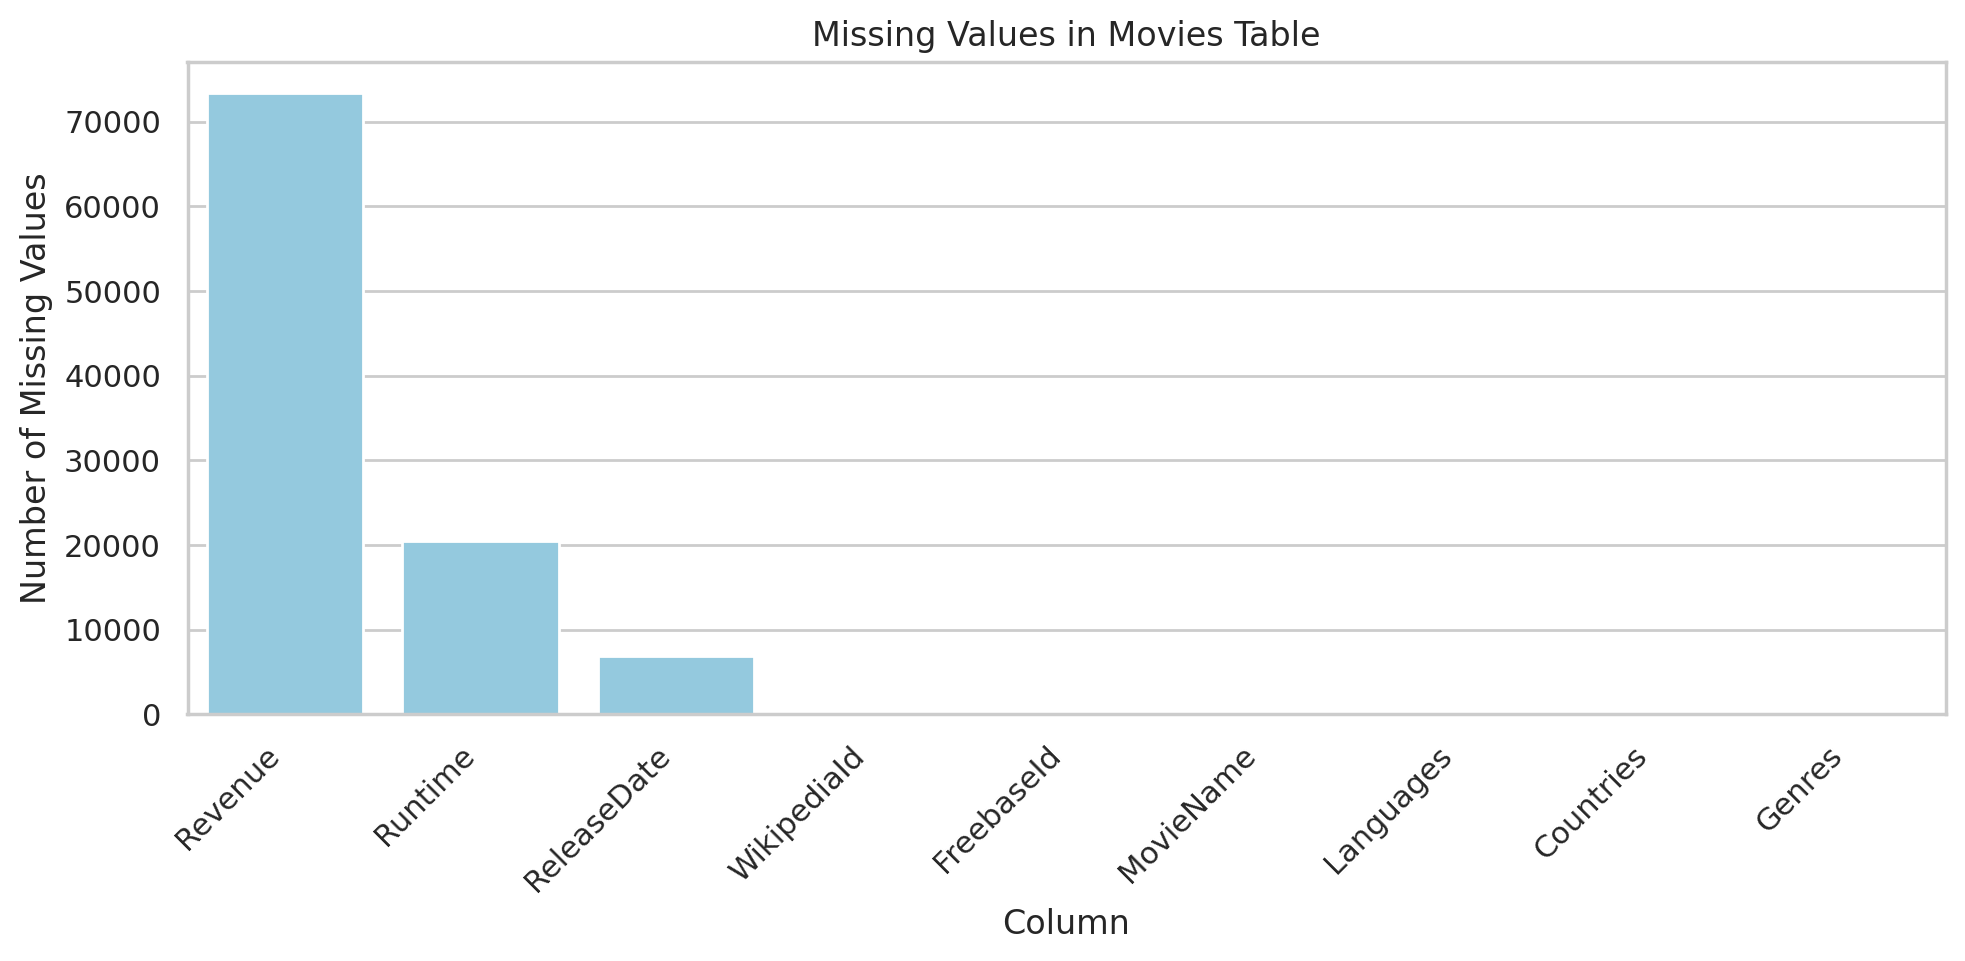

In [6]:
from src.utils.helpers import plot_nan_distribution

plot_nan_distribution(movies, table_name="Movies")

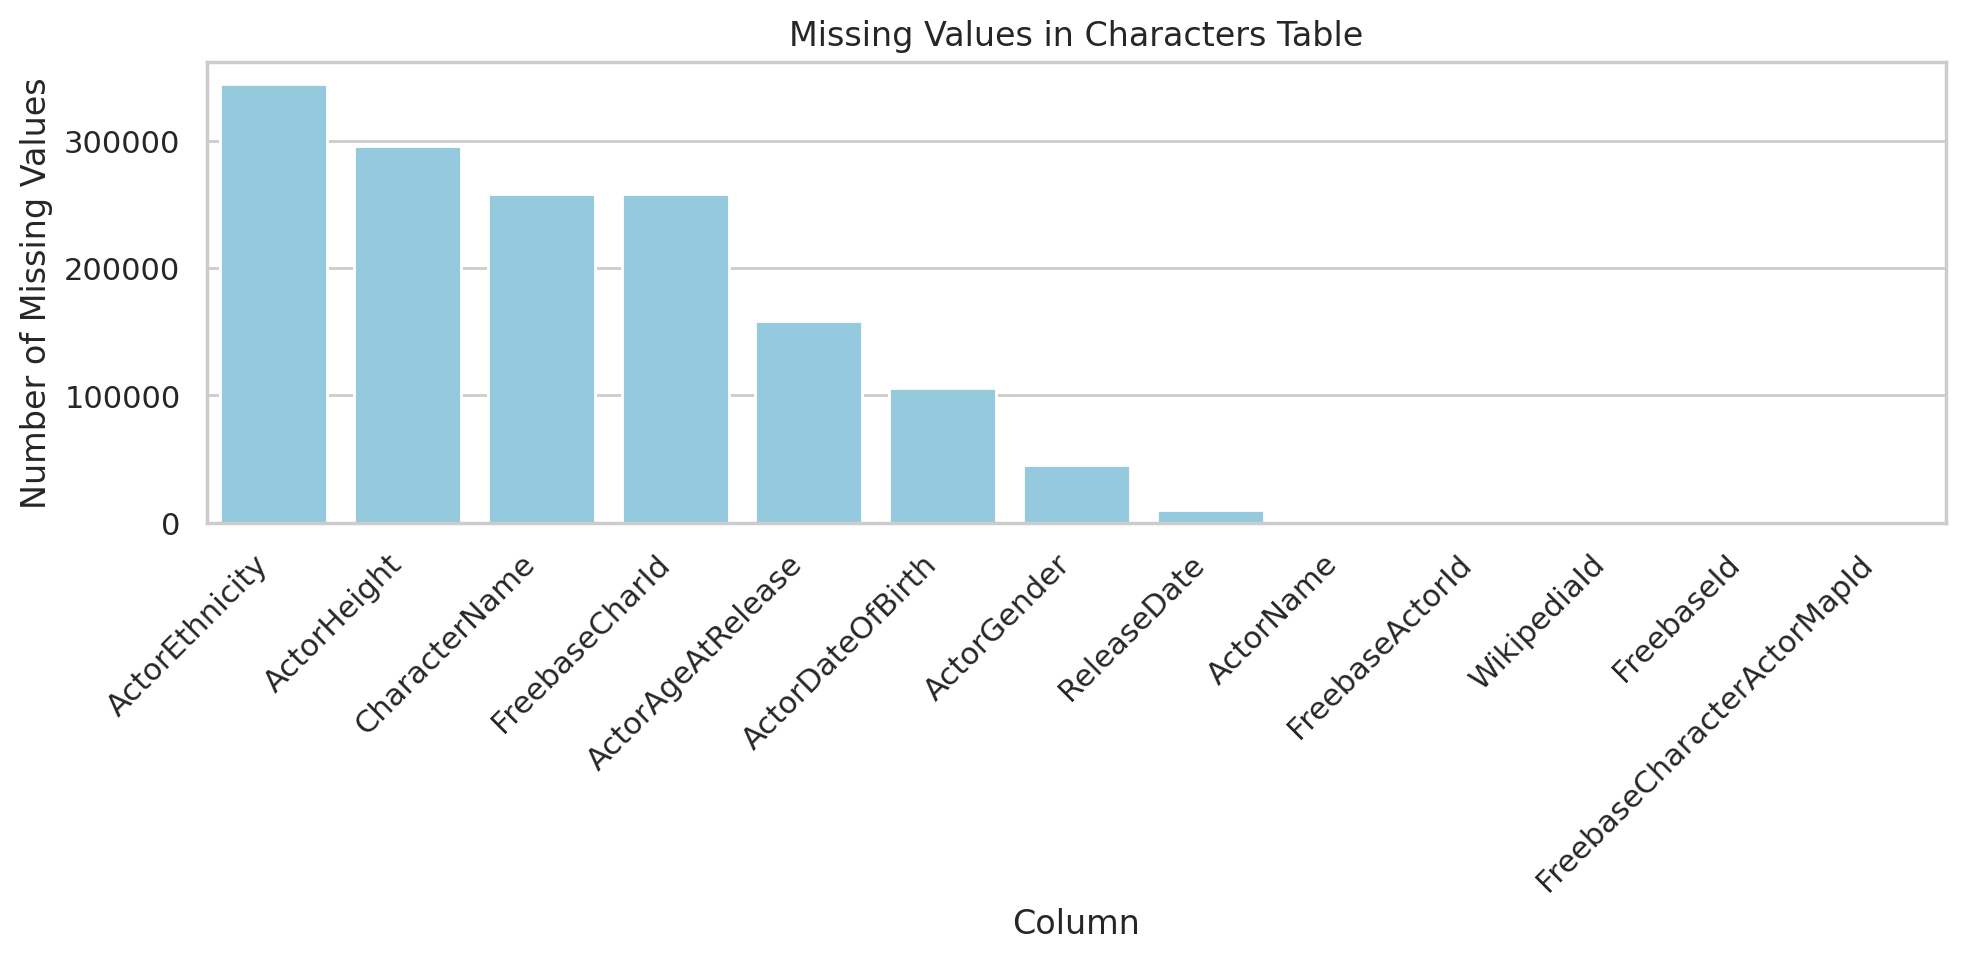

In [7]:
plot_nan_distribution(characters, table_name="Characters")

In [8]:
plot_nan_distribution(plots, table_name="Plots")

There is no Nans in Plots


We see that there are a lot of Nans, but, as described in the README, we want to focus on USA movies. We filter the dataset to get movies produced in the USA (i.e., has USA in the "Countries" column).

In [9]:
from src.utils.helpers import filter_by_country
us_movies = filter_by_country(movies, country="United States of America")
print("Number of US movies:", us_movies.shape[0])

Number of US movies: 34408


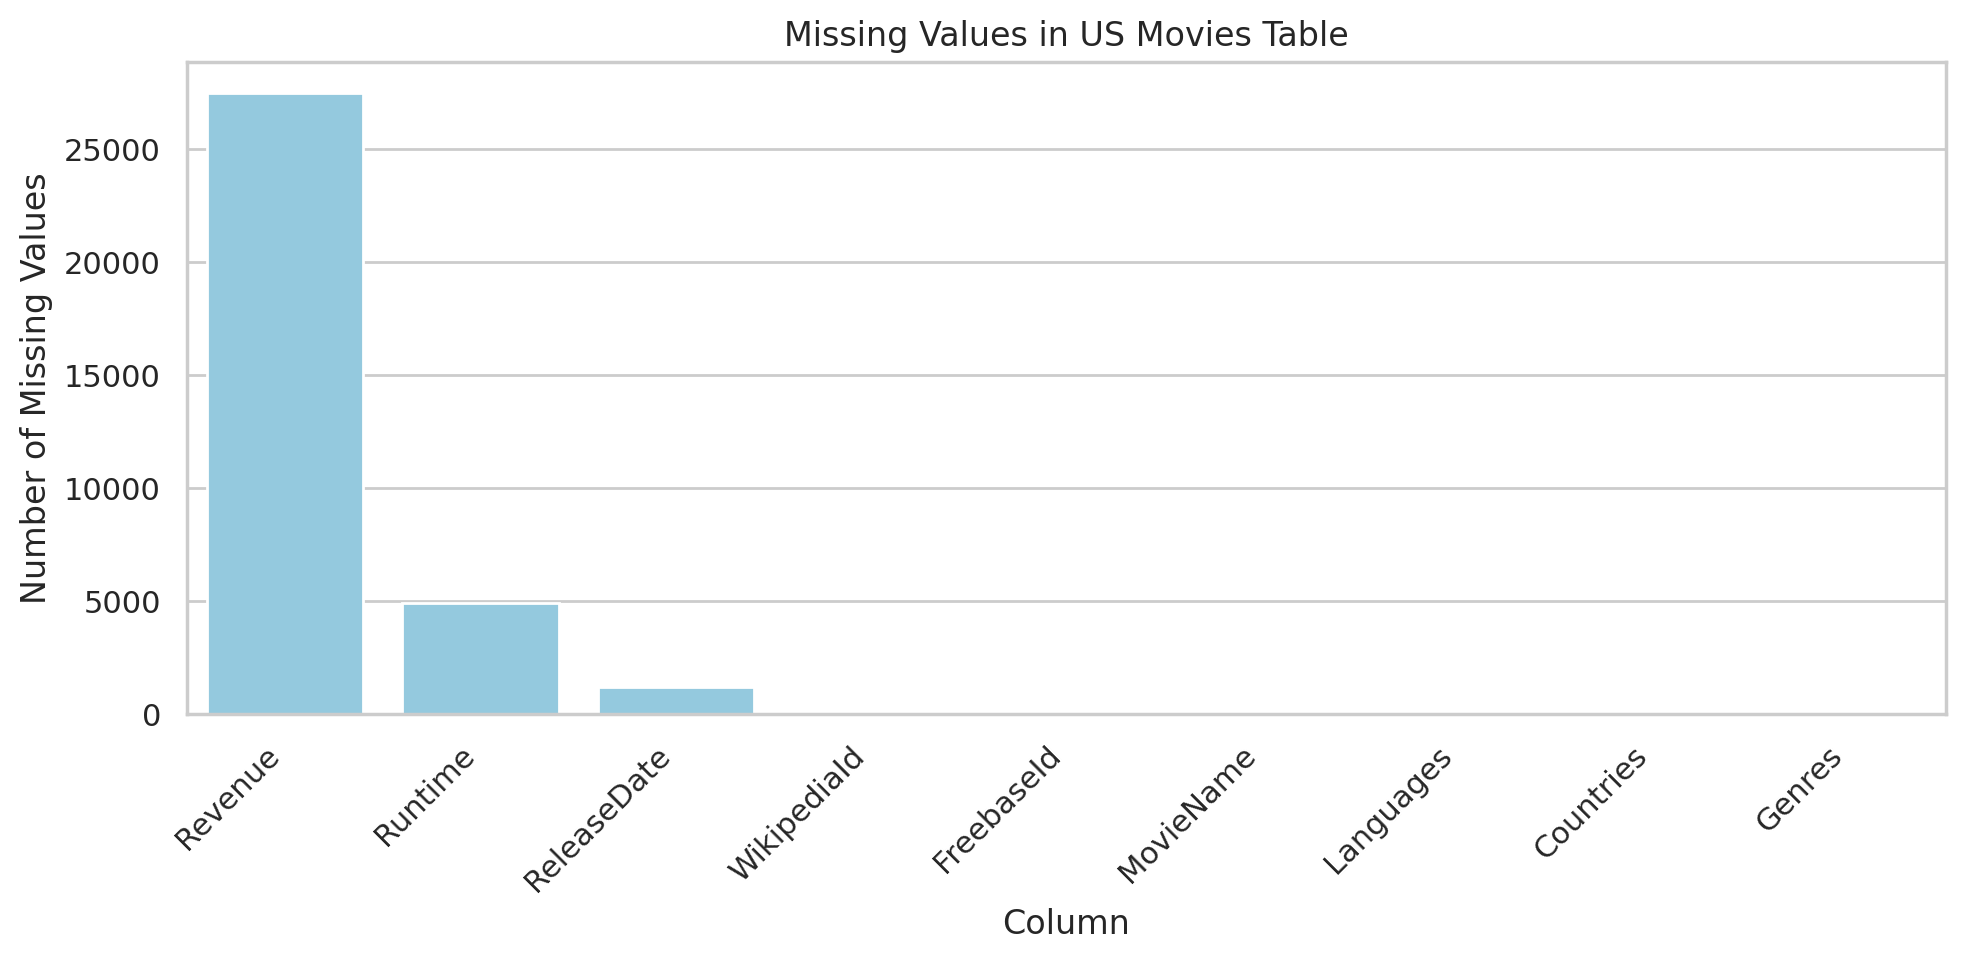

In [10]:
plot_nan_distribution(us_movies, table_name="US Movies")

As revenue is a core part of our analysis, we will drop the rows with missing revenue. We also want to investigate how clusters change in time, so we need the date information too and, therefore, keep only the non-Nan rows.

We also noticed that the ReleaseDate format is not fixed, so we change all values to a common format. 

In [11]:
from src.utils.helpers import drop_nans, fix_date

us_movies = drop_nans(us_movies, column="Revenue")
us_movies = drop_nans(us_movies, column="ReleaseDate")
us_movies = fix_date(us_movies, column="ReleaseDate")
print("Number of US movies after dropping Nans:", us_movies.shape[0])

Number of US movies after dropping Nans: 6923


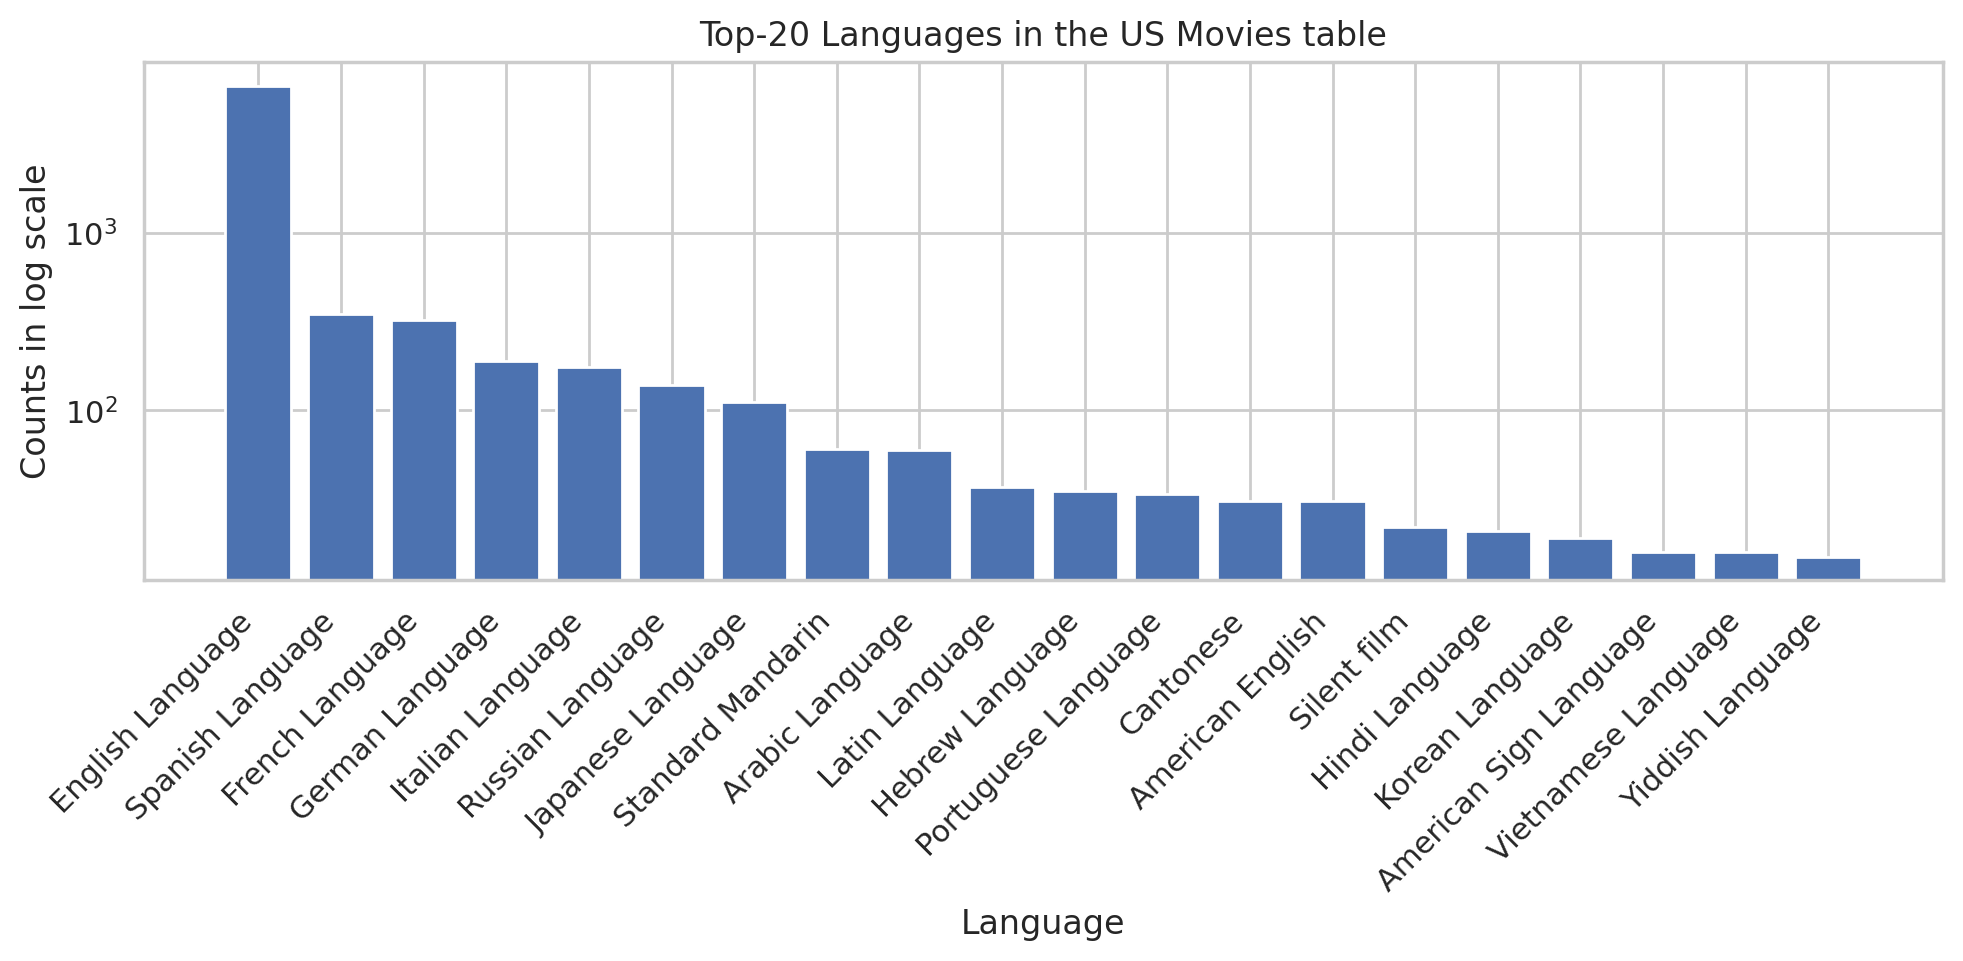

The top-1 language is in 97.91% of the movies


In [12]:
from src.utils.helpers import get_language_distribution
get_language_distribution(us_movies, table_name="US Movies", limit=20)

We see that English language is in $97.91\%$ of the movies. This, together with the plot, means that movies with other languages may be outliers for our analysis and bias the results. Thus, we remove movies that are not in English.

In [13]:
from src.utils.helpers import filter_by_language
us_movies = filter_by_language(us_movies, language="English Language")

Let's see the temporal distribution of our data after filtering.

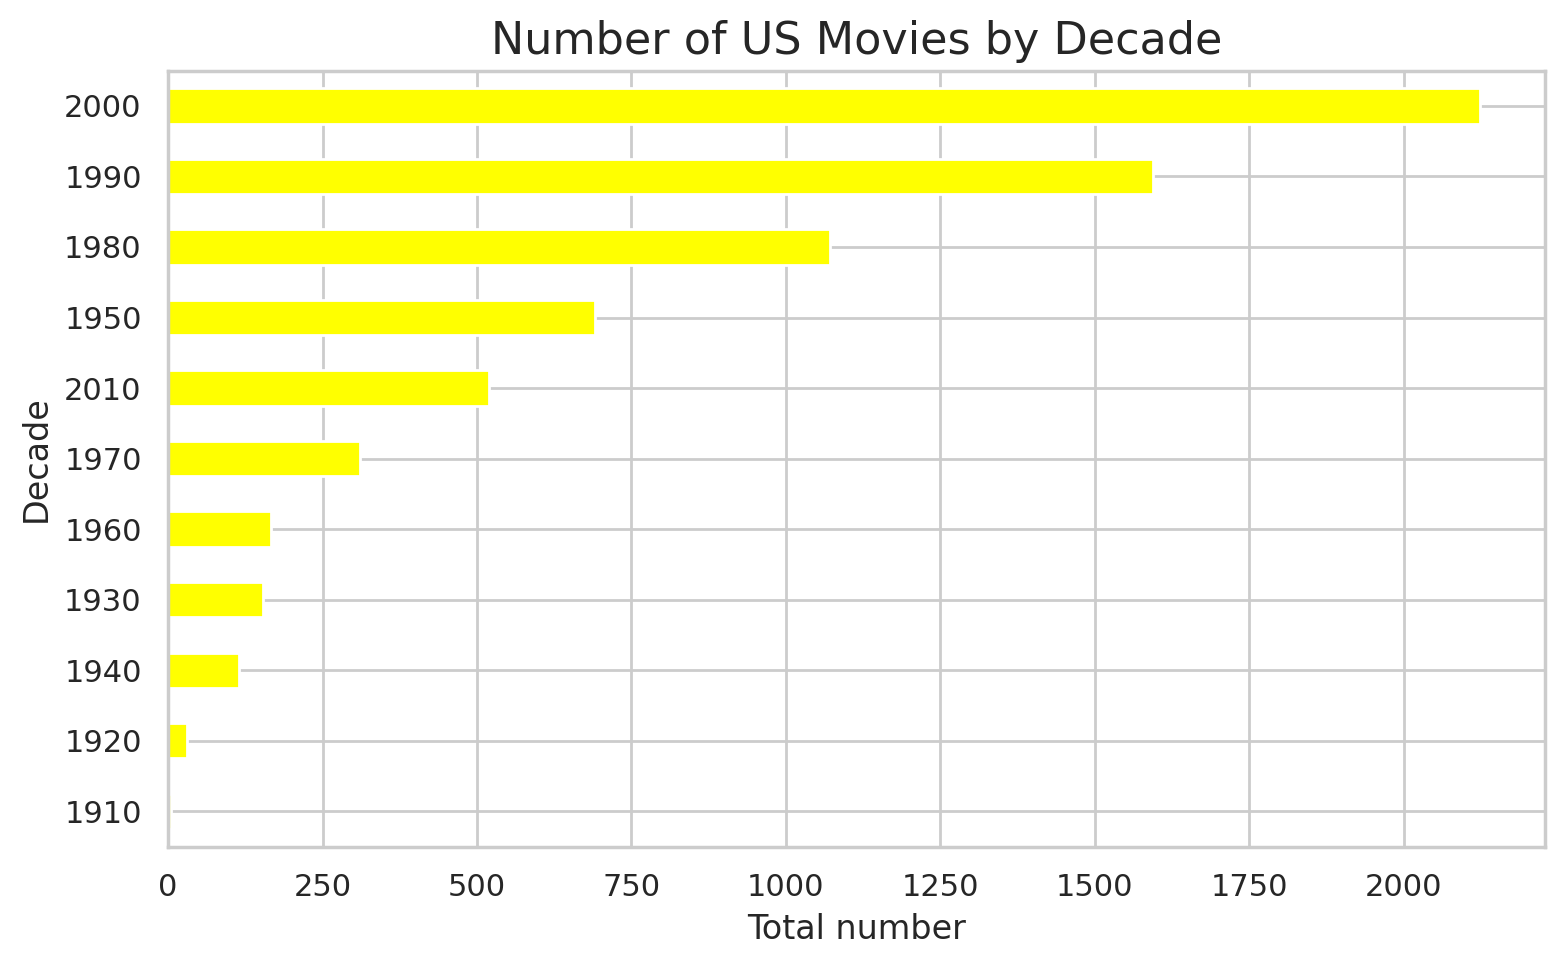

In [16]:
from src.utils.helpers import plot_decade_distribution
plot_decade_distribution(us_movies, table_name="US Movies")

Let's look at the revenue distribution:

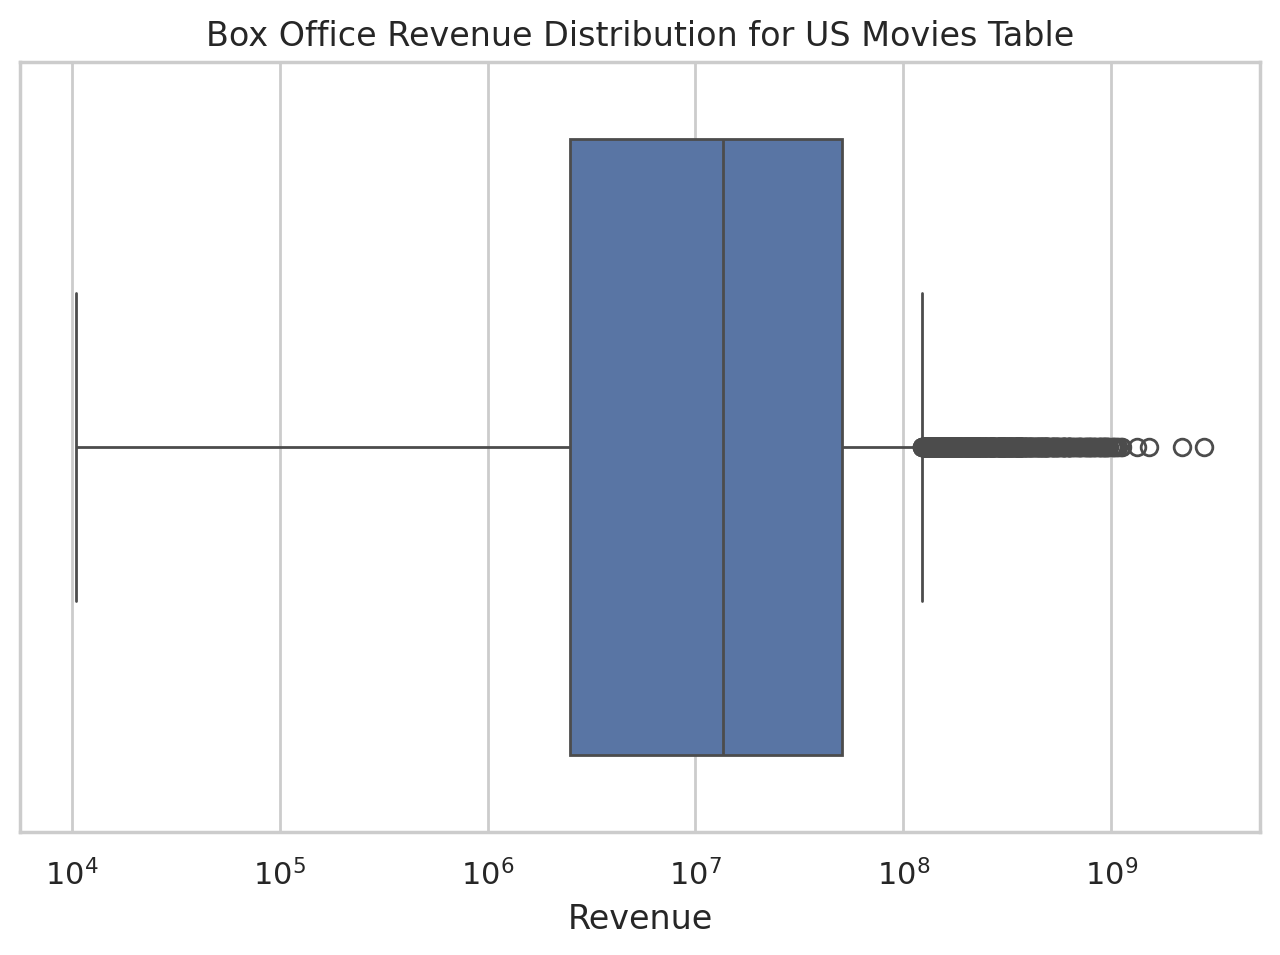

In [17]:
from src.utils.helpers import plot_revenue_distribution

plot_revenue_distribution(us_movies, table_name="US Movies")

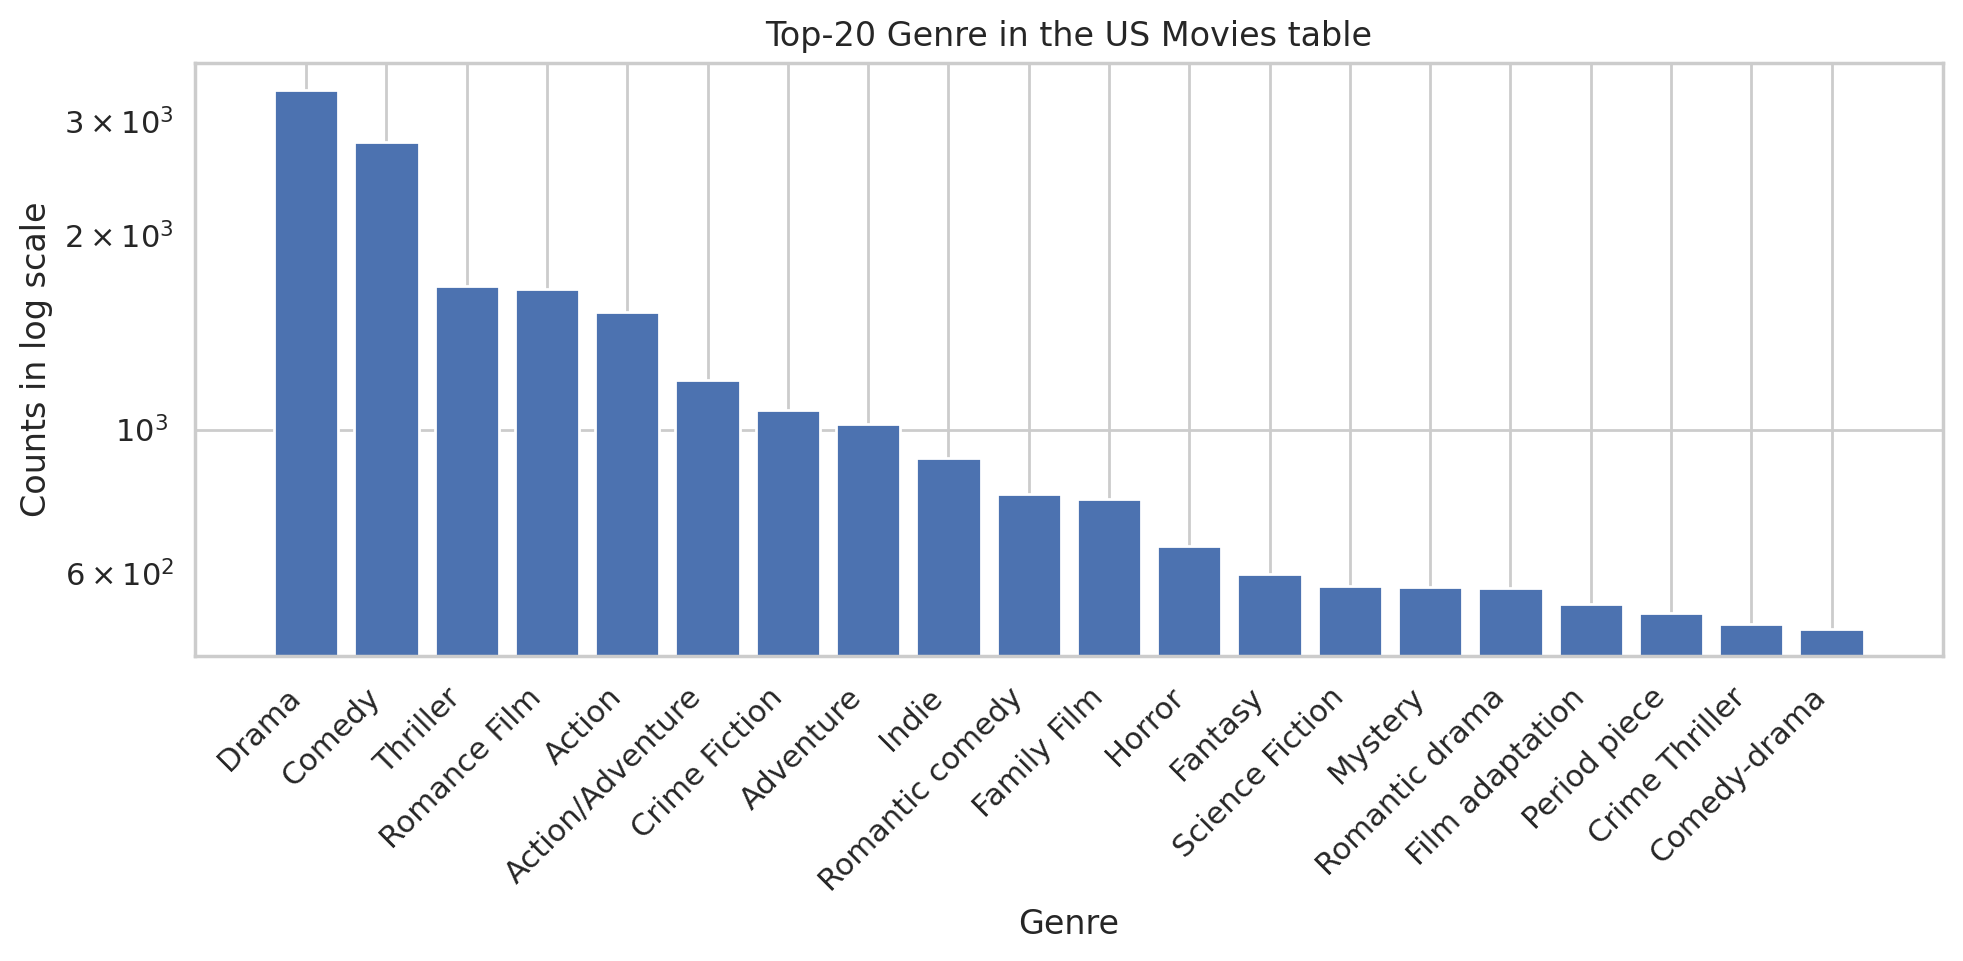

In [21]:
from src.utils.helpers import plot_top_genres

plot_top_genres(us_movies, table_name="US Movies", limit=20)

Now, let's move to `characters` table (also referred as `actors`).

In [22]:
from src.utils.actors import ActorStats

actor_stats = ActorStats(characters=characters, movies=us_movies)

At first, let's look at the statistics for a specific actor. For example, `/m/0c0k1` (Harrison Ford)

In [25]:
actor_id = "/m/0c0k1"
actor_stats.actor_name(actor_id)

'Harrison Ford'

In [27]:
actor_stats.actor_movies(actor_id).head(2)

,WikipediaId,FreebaseId,MovieName,ReleaseDate,Revenue,Runtime,Languages,Countries,Genres,Year,Decade
1983,43307,/m/0bw20,K-19: The Widowmaker,2002-07-19,65716126.0,138.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0cq22f9"": ""Actio...",2002,2000
2637,365039,/m/01_wsl,Six Days Seven Nights,1998-06-12,164839294.0,102.0,"{""/m/04306rv"": ""German Language"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03k9fj"": ""...",1998,1990


In [28]:
actor_stats.actor_prefered_genres(actor_id, n=4)

[('Drama', 23), ('Action', 17), ('Thriller', 15), ('Action/Adventure', 12)]

In [29]:
actor_stats.print_actor_stats(actor_id)

Name: Harrison Ford
  * Played in 35 movies.
  * Favourite genre: Drama (23 movies).
  * Total movie revenues:    6,397,871,819$.
  * Average movie revenue:     182,796,338$.


Our primary goal is to analyze clusters as described in the README. But before going into the cluster analysis, let's look at the whole picture by assigning all actors (participated in the `us_movies`) to a single cluster. This allows us to use the same functions without copy-pasting the code.

In [39]:
from src.utils.helpers import merge_movies_and_actors

movies_actors = merge_movies_and_actors(us_movies, characters)
# note that there might be movies without actors information
print("Total number of movies after merge:", movies_actors.groupby("WikipediaId").size().shape[0])

Total number of movies after merge: 6694


In [43]:
all_us_actors = movies_actors.FreebaseActorId.unique()
print("Total number of actors in the US movies:", all_us_actors.shape[0])

Total number of actors in the US movies: 30379


In [44]:
# create a single cluster of all us actors for the full analysis
from src.utils.actors import Cluster

full_cluster = Cluster(characters=characters, movies=us_movies, actor_ids=all_us_actors)

In [48]:
# full_cluster.cluster_mean_revenue()

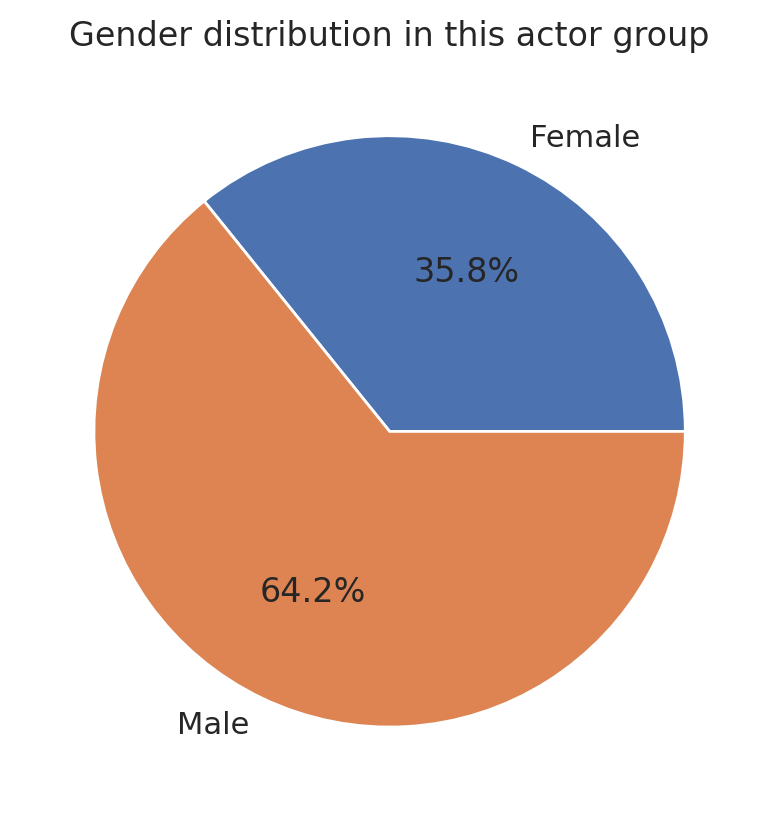

In [51]:
_ = full_cluster.cluster_genders(plot=True)

In [54]:
# _ = full_cluster.cluster_genres(plot=True)

# Partitioning 

## Verification of clusters quality